# Project Zephyr

In [1]:
import numpy as np
import math

### Designate Input Parameters

In [2]:
# Desired Mach number at exit
Me = 2
# Desired throat radius
At_radius = 0.02 # m
# Exit pressure of gas = atmospheric pressure at sea level (for ideal expansion)
Pe = 101.325 # kPa (atmospheric pressure at sea level)
# Combustion temperature
# Edit in combustion_optimiser: T_target

### Combustion Reaction

In [3]:
from combustion_optimiser import *

OFR = OFR_solution
k = k_products_solution
R = R_products_solution
Tc = T_target
rhoc = rho_products_solution

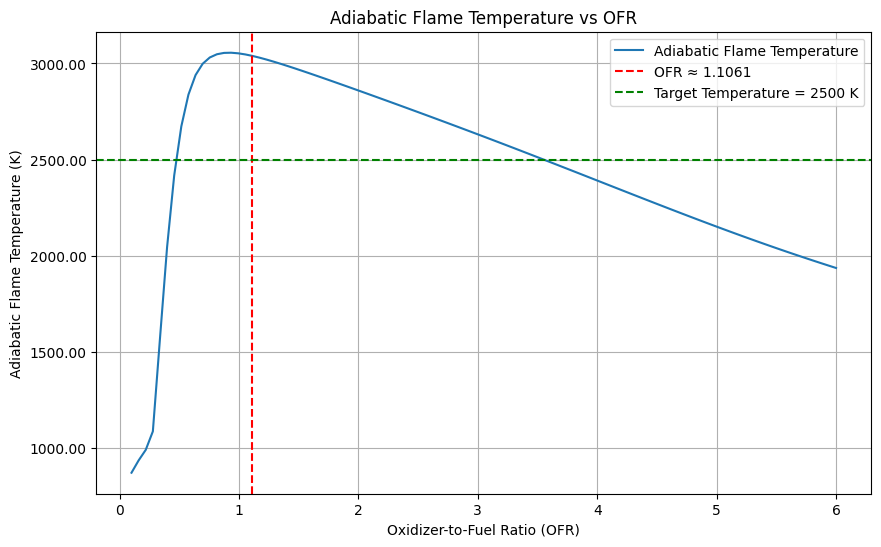

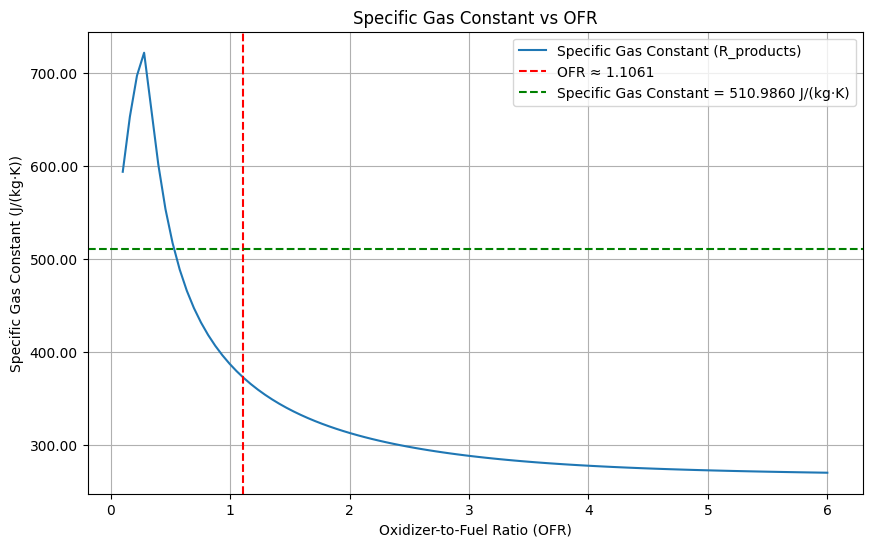

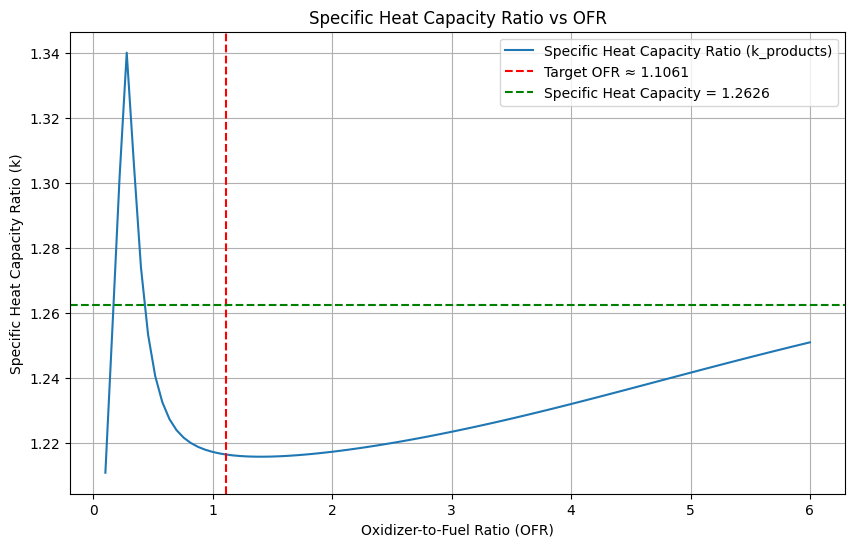

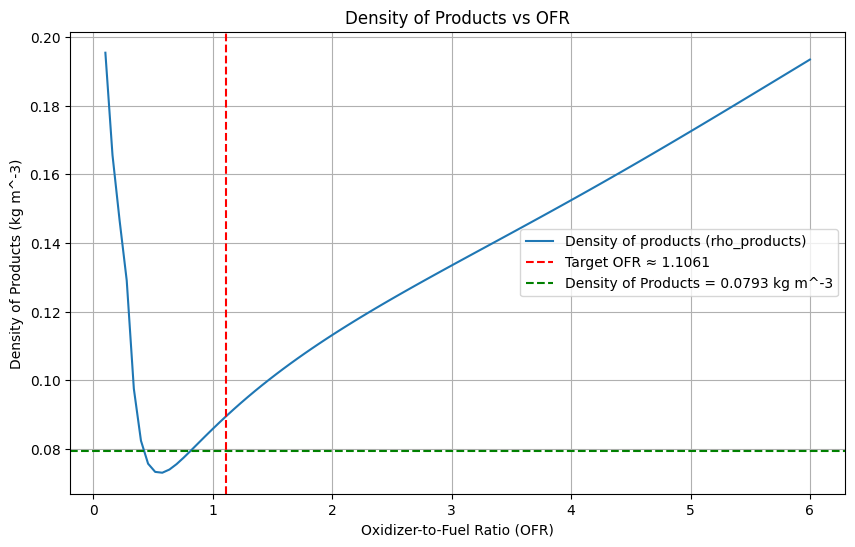

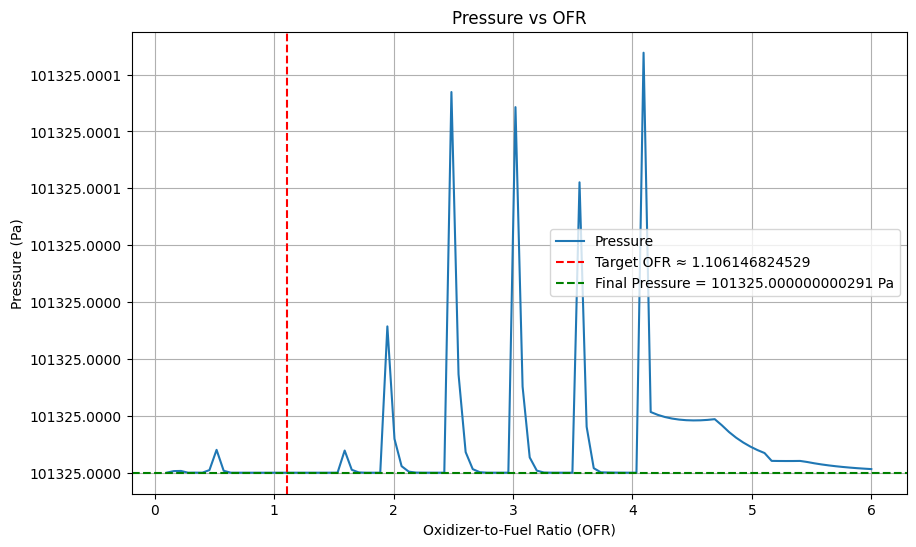

In [4]:
from combustion_plot import combustion_charts
combustion_charts(OFR_solution, T_target, OFR_values, T_final_values, R_products_values, k_products_values, rho_products_values, pressure_values, R_products_solution, k_products_solution, rho_products_solution, final_pressure)


#### Calculate Flame Speed

Flame speed (often denoted $S_L$ for laminar or $S_T$ for turbulent flames) describes the rate at which the flame front moves relative to the **unburnt gas mixture**. It characterizes how fast the chemical reaction advances through the unburnt reactants.

The following calculation simulates a freely-propagating, adiabatic, 1D flame. The output of the calculation is the laminar burning velocity and the estimated uncertainty in the laminar burning velocity calculation due to grid size. This allows us to determine the inlet velocity required to form flame seperation from the injector face, avoiding damage caused by heating.

In [27]:
from flame_speed import best_true_speed_estimate, best_total_percent_error_estimate
V_flame_uncertainty = best_total_percent_error_estimate
V_flame = best_true_speed_estimate

print(f"{V_flame:.2f} ± {V_flame_uncertainty:.4f} m/s")

2.86 ± 0.0005 m/s


A stable flame seperation distance occurs when the velocity at the flame front equals the flame speed: $v_f = S_f$

Bernoulli's equations can provide the velocity of the gas mixture along its streamline, this will be done in later calculations.

### Nozzle Isentropic Flow Relations

In [5]:
from nozzle_ratios import area_ratio_M, pressure_ratio, temperature_ratio, density_ratio

# Values used to isentropic flow relations plot
M_values = np.linspace(0.1, 10, 500)
Ar_Ma = area_ratio_M(M_values, k) 
Pr_Ma = pressure_ratio(M_values, k) 
Tr_Ma = temperature_ratio(M_values, k) 
rhor_Ma = density_ratio(M_values, k)

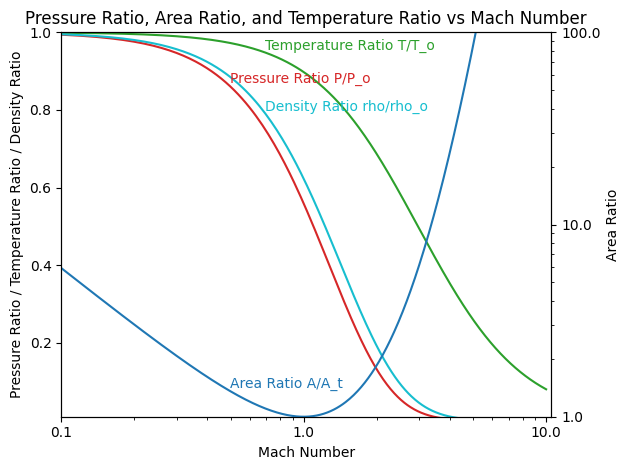

In [7]:
from ratio_plot import ratio_plot
ratio_plot(M_values, Pr_Ma, Ar_Ma, Tr_Ma, rhor_Ma)

### Nozzle Characteristics

In [9]:
# Area and Radius (m^2 / m):
At = math.pi * (At_radius)**2
A_nozzle_exit = area_ratio_M(Me, k) * At
R_exit = math.sqrt(A_nozzle_exit / math.pi)
A_nozzle_inlet = area_ratio_M(0.1, k) * At
R_inlet = math.sqrt(A_nozzle_inlet / math.pi)

# Pressure (kPa):
Pr_at_exit = pressure_ratio(Me, k)
Pc = Pe / Pr_at_exit
Pr_at_throat = pressure_ratio(1,k)
Pt = Pr_at_throat * Pc

# Temperature (K):
Tr_at_throat = temperature_ratio(1,k)
Tt = Tc * Tr_at_throat
Tr_at_exit = temperature_ratio(Me, k)
Te = Tc * Tr_at_exit

# Density (kgm^-3):
rho_at_throat = density_ratio(1,k)
rhot = rhoc * rho_at_throat
rho_at_exit = density_ratio(Me,k)
rhoe = rho_at_exit * rhoc

# Velocity (ms^1):
ut = math.sqrt(k * R * Tt)
term1 = (2 * k * R * Tc) / (k-1)
term2 = (k-1)/k
term3 = 1 - (Pr_at_exit ** term2)
ue = math.sqrt(term1 * term3)

In [25]:
import pandas as pd

# Data for display
print(f'OFR: {OFR_solution:.4f}')
data = {
    "Parameter": ["Radius (m)",  "Pressure (kPa)", "Temperature (K)", "Density (kg/m³)", "Velocity (m/s)"],
    "Combustion Chamber": [f"{R_inlet:.4f}", f"{Pc:.2f}", f"{Tc:.2f}", f"{rhoc:.2f}", "--"],
    "Throat": [f"{At_radius:.4f}",  f"{Pt:.2f}", f"{Tt:.2f}", f"{rhot:.2f}", f"{ut:.4f}"],
    "Exit": [f"{R_exit:.4f}",  f"{Pe:.2f}", f"{Te:.2f}", f"{rhoe:.2f}", f"{ue:.4f}"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display in Jupyter notebook
df


OFR: 3.5533


,Parameter,Combustion Chamber,Throat,Exit
0,Radius (m),0.0487,0.0200,0.0272
1,Pressure (kPa),766.47,428.53,101.33
2,Temperature (K),2500.00,2244.20,1717.12
3,Density (kg/m³),0.14,0.09,0.03
4,Velocity (m/s),--,881.0711,1541.3823


### Mass Flow Rate

WORK ON THIS

Mass flow rate is conserved throughout the engine, therefore mass flowrate in = mass flow rate out

As, F = m_dot * ue

In [7]:
m_dot = rho_at_throat * At * ut
m_dot_term1 = ((At * Pt) / math.sqrt(Tt))
m_dot_term2 = math.sqrt(k/R)
m_dot_term3 = ((k+1)/2)
m_dot_term4 = -((k+1)/(2*(k-1)))
m_dot_new = m_dot_term1 * m_dot_term2 * (m_dot_term3**m_dot_term4)
print(f"The mass flow rate of the engine is {m_dot:.2f} kg/s and {m_dot_new}")

The mass flow rate of the engine is 0.69 kg/s and 0.0004428792751912237


### Performance Parameters

#### Thrust

In [9]:
Fterm1 = (2*k**2) / (k-1)
Fterm2 = (2 / (k+1))**((k+1)/(k-1))
Fterm3 = 1 - (Pr_at_exit)**((k-1)/k)
F = At * Pc * math.sqrt(Fterm1 * Fterm2 * Fterm3) # missing effects of delta P at exit!!

#### Specific Impulse

In [10]:
# Isp:
Isp = ue / 9.81

#### Co-efficient of Thrust

In [11]:
# Coeffient of Thrust:
CF = F / (At * Pc)

#### Characteristic Velocity

The characteristic velocity (c*) is only a function of the propellant characteristics and combustion

chamber properties, independant of nozzle characteristics. Therefore, it can be used as a figure of 

merit when comparing different propellant combinations for combustion chamber performance.

In [12]:
c_star_term1 = math.sqrt(k * R * Tc)
c_star_term2 = (2/(k+1))**((k+1)/(k-1))

c_star = c_star_term1 / (k* math.sqrt(c_star_term2))
print(f"The Characteristic velocity of the engine is {c_star:.2f} m/s")

The Characteristic velocity of the engine is 1283.34 m/s


### Nozzle Geometry

#### Cone Design

In [15]:
# Convergent section using quarter circle shape
# Location of inflection:
r_inflection = 1.5*At_radius
print(f"Location of inflection is {r_inflection:.2f} m above throat edge, in line with throat. Circle with this radius created to form converging section")

# Tradeoff between nozzle performance and length of divergent section
re = math.sqrt(A_nozzle_exit/math.pi)
theta = np.linspace(12, 19, 500)
theta_radians = np.radians(theta)
L_cone = (re - At_radius) / np.tan(theta_radians)

Location of inflection is 0.03 m above throat edge, in line with throat. Circle with this radius created to form converging section


The aim is to maximise the correction factor (lambda->1) to reduce the wasted velocity, however we can see that when we try to maximise lambda, we result in a low half-angle which increase the length of the cone exponentially. Done using 'length_optimiser':

In [16]:
from length_optimiser import plot_and_optimize
# Example correction factor as a function of theta
ue_correction_factor = 1 - (theta - np.min(theta)) / (np.max(theta) - np.min(theta)) * 0.1  # Placeholder function

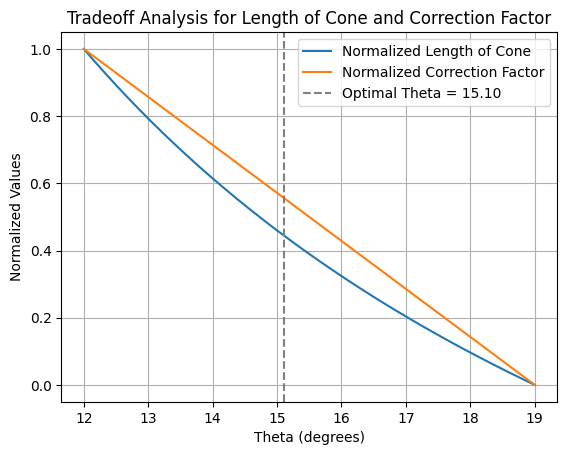

Optimal Theta: 15.1 deg
Optimal Length of Cone: 0.027 m
Optimal Correction Factor: 0.956


In [17]:
# Call the plot_and_optimize function
optimal_theta, optimal_L_cone, optimal_ue_correction_factor = plot_and_optimize(theta, L_cone, ue_correction_factor)

This length results in a radius of 160.193 mm at the exit which is 3mm different to the calculated radius where $P_e = P_{atm}$. The radius of the nozzle at the inlet from the inflection radius is 4.4mm off. These effects are negligible.

In [18]:
# Optimised Output
half_angle = optimal_theta
cone_length = optimal_L_cone
ue_lambda = optimal_ue_correction_factor
ue_corrected = ue*ue_lambda
print(f"The corrected exhaust velocity is {ue_corrected:.2f} m/s")

The corrected exhaust velocity is 1473.12 m/s


## Injector Design

In [19]:
inj_P_loss = Pc / 0.8